In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import glob
import json
import os
import sys
import statsmodels.api as st
from statsmodels.discrete.discrete_model import MNLogit
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
sys.path.append("/home/stacy/GitHub/SynRD/papers/marijuana19fairman/helpers")
sys.path.append("/home/stacy/GitHub/private-pgm/")
# sys.path.insert(1, "/home/stacy/GitHub/private-pgm/src")
from host_mst_wrapper.mst.mst import MSTSynthesizer
from host_mst_wrapper.mst.pmse import pmse_ratio
from helpers import plot_figure, get_encoded_df, get_unencoded_df, load_data, get_aOR

# MST

In [3]:
df = load_data()
df.shape

(296467, 6)

In [4]:
df.dtypes

YEAR          int64
CLASS        object
SEX          object
RACE         object
AGE_GROUP    object
AGE           int64
dtype: object

In [5]:
df_enc = get_encoded_df(df)
df_enc.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
0,6,2,1,2,4,8
1,6,2,0,3,1,3
2,6,0,0,6,3,6
3,6,3,1,3,0,1
4,6,5,1,3,4,8


In [6]:
%%time
avg_pmse = 0
seeds = range(20)
for s in seeds:
    avg_pmse += pmse_ratio(df_enc, df_enc, seed=s)
print('Average pMSE:',round(avg_pmse/len(seeds),3))

Average pMSE: 1.03
CPU times: user 30.4 s, sys: 48 s, total: 1min 18s
Wall time: 11 s


In [7]:
df_domain = {
    "YEAR": 11,
    "CLASS": 6,
    "SEX": 2,
    "RACE": 7,
    "AGE_GROUP": 5,
    "AGE": 10,
}

domain_file_name = 'nsduh_processed_domain.json'
domain_file_path = os.path.join('../../data', domain_file_name)
with open(domain_file_path, 'w') as domain_file:
    json.dump(df_domain, domain_file)

In [8]:
%%time
cliques_to_try = [
    [],
    [('SEX', 'AGE_GROUP'), ('AGE_GROUP', 'RACE')],
    [('SEX', 'CLASS'), ('AGE_GROUP', 'CLASS'), ('RACE', 'CLASS')]
]

for cl in cliques_to_try:
    synth = MSTSynthesizer(epsilon=1.0, 
                        domain_path=domain_file_path,
                        custom_cliques=True,
                        cliques_set=cl)
    synth.fit(df_enc)
    mst_fake_data = synth.sample(samples=len(df_enc))
    avg_pmse = 0
    for s in seeds:
        avg_pmse += pmse_ratio(df_enc, mst_fake_data, seed=s)
    print('Average pMSE:',round(avg_pmse/len(seeds),3))
    print('')

Domain(YEAR: 11, CLASS: 6, SEX: 2, RACE: 7, AGE_GROUP: 5, AGE: 10)
Index(['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP', 'AGE'], dtype='object')
[]
Average pMSE: 1.189

Domain(YEAR: 11, CLASS: 6, SEX: 2, RACE: 7, AGE_GROUP: 5, AGE: 10)
Index(['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP', 'AGE'], dtype='object')
[('SEX', 'AGE_GROUP'), ('AGE_GROUP', 'RACE')]
Average pMSE: 1.201

Domain(YEAR: 11, CLASS: 6, SEX: 2, RACE: 7, AGE_GROUP: 5, AGE: 10)
Index(['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP', 'AGE'], dtype='object')
[('SEX', 'CLASS'), ('AGE_GROUP', 'CLASS'), ('RACE', 'CLASS')]
Average pMSE: 1.078

CPU times: user 2min 56s, sys: 2min 57s, total: 5min 53s
Wall time: 1min 52s


In [9]:
%%time
synth = MSTSynthesizer(epsilon=1.0, 
                        domain_path=domain_file_path)
synth.fit(df_enc)
mst_fake_data = synth.sample(samples=len(df_enc))

Domain(YEAR: 11, CLASS: 6, SEX: 2, RACE: 7, AGE_GROUP: 5, AGE: 10)
Index(['YEAR', 'CLASS', 'SEX', 'RACE', 'AGE_GROUP', 'AGE'], dtype='object')
[('YEAR', 'CLASS'), ('CLASS', 'AGE'), ('CLASS', 'RACE'), ('CLASS', 'SEX'), ('AGE_GROUP', 'AGE')]
CPU times: user 29.5 s, sys: 71.1 ms, total: 29.6 s
Wall time: 29.6 s


In [10]:
mst_fake_data.dtypes

YEAR         int64
CLASS        int64
SEX          int64
RACE         int64
AGE_GROUP    int64
AGE          int64
dtype: object

In [11]:
df_fake = get_unencoded_df(df, mst_fake_data)
df_fake['SEX'] = df_fake['SEX'].astype('category')
df_fake['RACE'] = df_fake['RACE'].astype('category')
df_fake['AGE_GROUP'] = df_fake['AGE_GROUP'].astype('category')
df_fake['CLASS'] = df_fake['CLASS'].astype('category')
df_fake['YEAR'] = df_fake['YEAR'].astype('category')
df_fake['AGE'] = df_fake['AGE'].astype('category')
df_fake.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
0,2012,MARIJUANA,Male,Hispanic,20-21,20
1,2010,OTHER_DRUGS,Male,Asian,14-15,15
2,2007,NO_DRUG_USE,Male,Hispanic,16-17,16
3,2010,NO_DRUG_USE,Male,White,14-15,15
4,2008,ALCOHOL,Female,White,20-21,21


In [12]:
df_fake.dtypes

YEAR         category
CLASS        category
SEX          category
RACE         category
AGE_GROUP    category
AGE          category
dtype: object

## Compare true and synthetic data

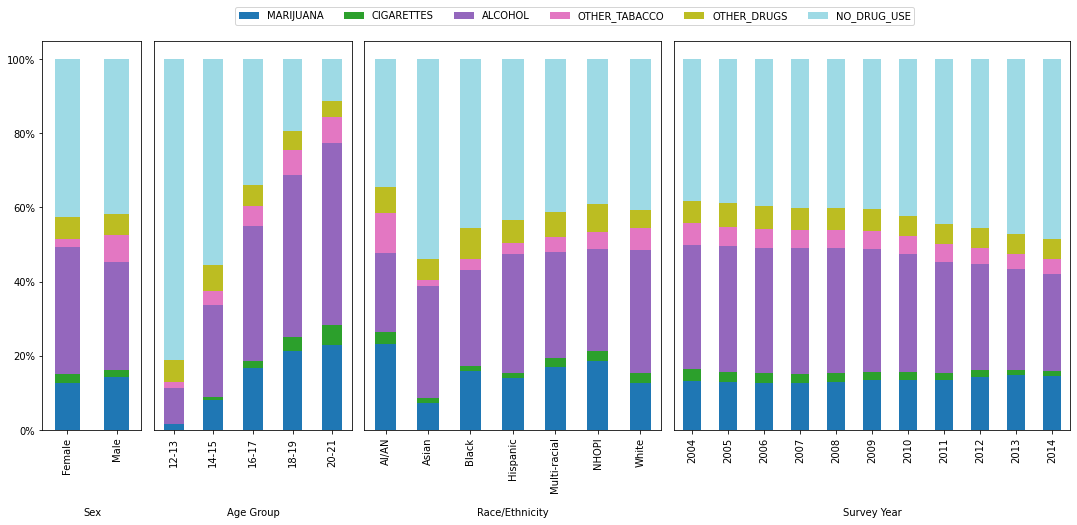

In [13]:
plot_figure(df)

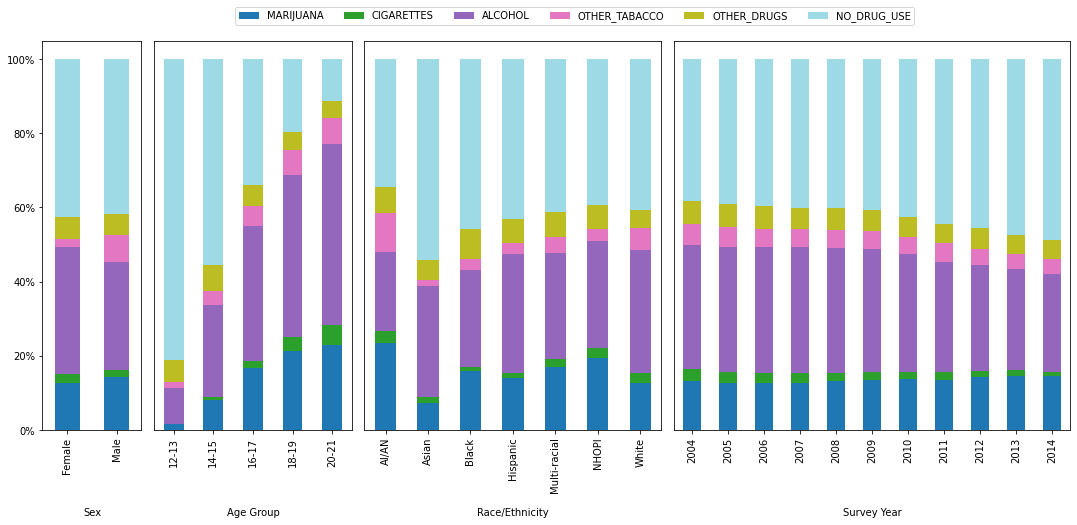

In [14]:
plot_figure(df_fake)

In [15]:
df.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
0,2010,MARIJUANA,Male,Black,20-21,20
1,2010,MARIJUANA,Female,Hispanic,14-15,15
2,2010,ALCOHOL,Female,White,18-19,18
3,2010,NO_DRUG_USE,Male,Hispanic,12-13,13
4,2010,OTHER_TABACCO,Male,Hispanic,20-21,20


In [16]:
df_fake.head()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
0,2012,MARIJUANA,Male,Hispanic,20-21,20
1,2010,OTHER_DRUGS,Male,Asian,14-15,15
2,2007,NO_DRUG_USE,Male,Hispanic,16-17,16
3,2010,NO_DRUG_USE,Male,White,14-15,15
4,2008,ALCOHOL,Female,White,20-21,21


In [17]:
df.describe()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
count,296467,296467,296467,296467,296467,296467
unique,11,6,2,7,5,10
top,2011,NO_DRUG_USE,Male,White,16-17,16
freq,29121,125152,148945,175218,66936,33853


In [18]:
df_fake.describe()

,YEAR,CLASS,SEX,RACE,AGE_GROUP,AGE
count,296467,296467,296467,296467,296467,296467
unique,11,6,2,7,5,10
top,2011,NO_DRUG_USE,Male,White,16-17,16
freq,29119,125198,148944,175242,66938,33837


In [19]:
def compare(df, df_fake, column_name):
    return pd.DataFrame([
            df[column_name].value_counts(),
            df_fake[column_name].value_counts(),
            df[column_name].value_counts() - df_fake[column_name].value_counts()
    ], index=['real', 'mst', 'diff'])

In [20]:
class_compare = compare(df, df_fake, 'CLASS')
class_compare

,NO_DRUG_USE,ALCOHOL,MARIJUANA,OTHER_DRUGS,OTHER_TABACCO,CIGARETTES
real,125152,93652,39914,16875,14320,6554
mst,125198,93650,39908,16883,14296,6532
diff,-46,2,6,-8,24,22


In [21]:
class_compare.sum(axis=1)

real    296467
mst     296467
diff         0
dtype: int64

# aOR

In [39]:
aOR = get_aOR(df)
aOR

Optimization terminated successfully.
         Current function value: 1.213960
         Iterations 8


Marijuana vs. No Drug                            \
                                         aOR Lower CI Higher CI pvalue   
Male vs. Female                        1.334    1.303     1.366    0.0   
White vs. AI/AN                        0.341    0.313     0.373    0.0   
White vs. Asian                        1.676    1.544     1.820    0.0   
White vs. Black                        0.623    0.601     0.645    0.0   
White vs. Hispanic                     0.871    0.844     0.899    0.0   
White vs. Multi-racial                 0.626    0.591     0.663    0.0   
White vs. NHOPI                        0.580    0.495     0.679    0.0   
AGE                                    0.932    0.927     0.936    0.0   
YEAR                                   0.965    0.961     0.969    0.0   

                       Marijuana vs. Cigarettes                            \
                                            aOR Lower CI Higher CI pvalue   
Male vs. Female                           1.476    1.399     1.556  0.000   
White vs. AI/AN                           0.634    0.532     0.756  0.000   
White vs. Asian                           0.787    0.651     0.950  0.013   
White vs. Black                           0.344    0.312     0.379  0.000   
White vs. Hispanic                        0.417    0.382     0.454  0.000   
White vs. Multi-racial                    0.707    0.622     0.804  0.000   
White vs. NHOPI                           0.663    0.471     0.935  0.019   
AGE                                       1.146    1.133     1.160  0.000   
YEAR                                      0.912    0.904     0.920  0.000   

                       Marijuana vs. Alcohol                            
                                         aOR Lower CI Higher CI pvalue  
Male vs. Female                        1.241    1.211     1.273  0.000  
White vs. AI/AN                        0.399    0.365     0.436  0.000  
White vs. Asian                        3.345    3.075     3.638  0.000  
White vs. Black                        0.992    0.958     1.028  0.668  
White vs. Hispanic                     0.974    0.942     1.007  0.118  
White vs. Multi-racial                 0.617    0.581     0.655  0.000  
White vs. NHOPI                        0.733    0.622     0.865  0.000  
AGE                                    0.580    0.577     0.583  0.000  
YEAR                                   1.028    1.023     1.032  0.000

In [40]:
syn_aOR = get_aOR(df_fake)
syn_aOR

Optimization terminated successfully.
         Current function value: 1.217062
         Iterations 8


Marijuana vs. No Drug                            \
                                         aOR Lower CI Higher CI pvalue   
Male vs. Female                        1.311    1.281     1.343    0.0   
White vs. AI/AN                        0.338    0.309     0.369    0.0   
White vs. Asian                        1.543    1.421     1.675    0.0   
White vs. Black                        0.617    0.596     0.639    0.0   
White vs. Hispanic                     0.855    0.829     0.883    0.0   
White vs. Multi-racial                 0.628    0.593     0.666    0.0   
White vs. NHOPI                        0.563    0.482     0.657    0.0   
AGE                                    0.933    0.929     0.938    0.0   
YEAR                                   0.962    0.958     0.966    0.0   

                       Marijuana vs. Cigarettes                            \
                                            aOR Lower CI Higher CI pvalue   
Male vs. Female                           1.476    1.399     1.556  0.000   
White vs. AI/AN                           0.658    0.554     0.782  0.000   
White vs. Asian                           0.870    0.724     1.045  0.136   
White vs. Black                           0.330    0.299     0.364  0.000   
White vs. Hispanic                        0.414    0.381     0.451  0.000   
White vs. Multi-racial                    0.607    0.532     0.692  0.000   
White vs. NHOPI                           0.641    0.455     0.903  0.011   
AGE                                       1.138    1.125     1.152  0.000   
YEAR                                      0.908    0.900     0.916  0.000   

                       Marijuana vs. Alcohol                            
                                         aOR Lower CI Higher CI pvalue  
Male vs. Female                        1.152    1.123     1.181  0.000  
White vs. AI/AN                        0.446    0.408     0.487  0.000  
White vs. Asian                        2.266    2.085     2.463  0.000  
White vs. Black                        0.890    0.859     0.922  0.000  
White vs. Hispanic                     0.947    0.916     0.979  0.001  
White vs. Multi-racial                 0.753    0.709     0.799  0.000  
White vs. NHOPI                        0.642    0.546     0.755  0.000  
AGE                                    0.586    0.583     0.589  0.000  
YEAR                                   1.010    1.006     1.014  0.000

# temp

In [37]:
def get_log_reg(df):
    class_mapping = {
        'MARIJUANA': 0,
        'ALCOHOL': 1,
        'CIGARETTES': 2,
        'NO_DRUG_USE': 3,
        'OTHER_TABACCO': 4,
        'OTHER_DRUGS': 5
    }
    data = df.copy()
    data['CLASS'] = data.CLASS.map(class_mapping)
    data['CLASS'] = data.CLASS.astype(np.int32)
    data['AGE'] = data.AGE.astype(np.int32)
    data['YEAR'] = data.YEAR.astype(np.int32)
    model = st.MNLogit.from_formula(
        'CLASS ~ C(SEX, Treatment(reference="Male")) + AGE + C(RACE, Treatment(reference="White")) + YEAR',
        data=data)
    log_reg = model.fit(method='newton', maxiter=100, full_output=True)
    return log_reg

def get_aOR(df):
    headers = ['Marijuana vs. No Drug', 'Marijuana vs. Cigarettes', 'Marijuana vs. Alcohol']
    log_reg = get_log_reg(df)
    dfs = []
    lower_CI = log_reg.conf_int()['lower']
    upper_CI = log_reg.conf_int()['upper']
    for indx in [0, 1, 2]:
        dfs.append(
            pd.DataFrame(
                {
                    "aOR": np.exp(log_reg.params[indx]),
                    "Lower CI": np.exp(lower_CI.iloc[lower_CI.index.get_level_values('CLASS') == str(indx + 1)].values),
                    "Higher CI": np.exp(upper_CI.iloc[upper_CI.index.get_level_values('CLASS') == str(indx + 1)].values),
                    "pvalue": log_reg.pvalues[indx],
                }
            )
        )

    aOR = pd.concat(dfs, axis=1, keys=headers, levels=[headers])
    aOR = aOR.drop('Intercept')
    aOR.index = [x[-1].replace(')', '').replace('T.', '').replace('"', '').replace('[', ' vs. ').replace(']', '') for x in aOR.index.str.split('reference=')]
    aOR = round(aOR, 3)
    return aOR

--------------------